In [2]:
pip install --upgrade pip

Keyring is skipped due to an exception: 'keyring.backends'
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.3 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 47.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 8.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.9 MB/s eta

In [7]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib as mpl

In [8]:
tf.__version__

'2.11.0'

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
porter = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
class Emotion:
  def __init__(self, datasetFolder, batch_size, validation_split, optimizer, loss, epochs):
    self.datasetFolder = datasetFolder
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
  def readDatasetCSV(self):
    trainDataset = pd.read_csv(os.path.join(self.datasetFolder, "train.txt"), names=['Text', 'Emotion'], sep=';')
    testDataset = pd.read_csv(os.path.join(self.datasetFolder, "test.txt"), names=['Text', 'Emotion'], sep=';')
    validDataset = pd.read_csv(os.path.join(self.datasetFolder, "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [trainDataset, testDataset, validDataset]
    self.dataset = pd.concat(list_dataset)
  def FeaturesLables(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion']  
  def splitDataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def CleanFeatures(self):
    self.features = self.features.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
    self.features = self.features.apply(lambda wrd: ''.join(wrd))
  def tokenizerDataset(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    train = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(train)
    le = LabelEncoder()
    self.labels = le.fit_transform(self.labels)
    self.vocabulary = len(self.tokenizer.word_index)
  def label_categorical(self):
    self.labels = to_categorical(self.labels, 6)
  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name)
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector  
  def model(self):
    m = Sequential()
    m.add(Input(shape=(self.features.shape[1], )))
    m.add(Embedding(self.vocabulary + 1,300))
    m.add(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    m.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.m = m
  def compiler(self):
    self.m.compile(loss= self.loss,optimizer=self.optimizer,metrics=['accuracy'])
  def fit(self):
    earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
    self.history_training = self.m.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks=[ earlyStopping])

In [11]:
dataset_emotion = "emotions-dataset-for-nlp"

In [25]:
emotion = Emotion(dataset_emotion, 256, 0.1, 'adam', 'categorical_crossentropy', 20)
emotion.readDatasetCSV()
emotion.dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [26]:
emotion.FeaturesLables()
emotion.CleanFeatures()
emotion.features.head()

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [27]:
emotion.labels.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [28]:
emotion.tokenizerDataset()
emotion.features

array([[   0,    0,    0, ...,  138,    2,  625],
       [   0,    0,    0, ...,    3,   21, 1383],
       [   0,    0,    0, ...,    2,  495,  420],
       ...,
       [   0,    0,    0, ...,    5,  215,  191],
       [   0,    0,    0, ...,   30,   57, 2181],
       [   0,    0,    0, ...,   75,    5,   70]], dtype=int32)

In [29]:
emotion.labels

array([4, 4, 0, ..., 2, 2, 2])

In [30]:
emotion.features.shape

(20000, 63)

In [31]:
emotion.label_categorical()
emotion.labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [19]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-11-20 06:19:18--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-20 06:19:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2022-11-20 06:21:59 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [20]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [33]:
emotion.splitDataset()
emotion.glove_word_embedding("glove.6B.300d.txt")

In [34]:
emotion.model()
emotion.m.layers[0].set_weights([emotion.embedding_matrix])
emotion.m.layers[0].trainable = False

In [35]:
emotion.compiler()
emotion.m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 gru_2 (GRU)                 (None, 128)               165120    
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 5,294,994
Trainable params: 165,894
Non-trainable params: 5,129,100
_________________________________________________________________


In [36]:
emotion.fit()

Epoch 1/20
71/71 [==============================] - 39s 519ms/step - loss: 1.3828 - accuracy: 0.4860
Epoch 2/20
71/71 [==============================] - 35s 499ms/step - loss: 0.8182 - accuracy: 0.7173
Epoch 3/20
71/71 [==============================] - 38s 542ms/step - loss: 0.4484 - accuracy: 0.8485
Epoch 4/20
71/71 [==============================] - 38s 539ms/step - loss: 0.2896 - accuracy: 0.8990
Epoch 5/20
71/71 [==============================] - 38s 532ms/step - loss: 0.2210 - accuracy: 0.9172
Epoch 6/20
71/71 [==============================] - 38s 531ms/step - loss: 0.1796 - accuracy: 0.9279
Epoch 7/20
71/71 [==============================] - 36s 512ms/step - loss: 0.1543 - accuracy: 0.9361
Epoch 8/20
71/71 [==============================] - 35s 497ms/step - loss: 0.1355 - accuracy: 0.9435
Epoch 9/20
71/71 [==============================] - 36s 504ms/step - loss: 0.1205 - accuracy: 0.9496
Epoch 10/20
71/71 [==============================] - 35s 495ms/step - loss: 0.1127 - accura

In [37]:
model.evaluate(x_val,y_val,verbose=1)

NameError: name 'model' is not defined

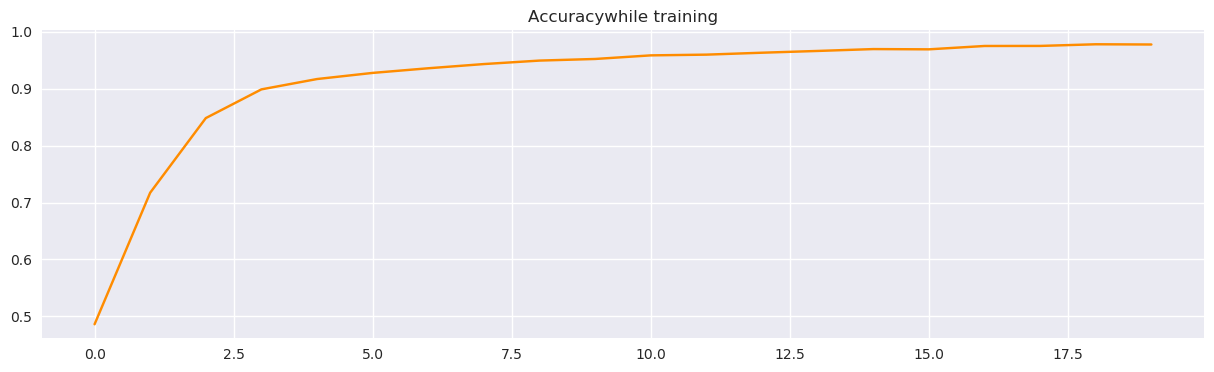

In [38]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['accuracy'], 'darkorange', label = 'Accuracy')
plt.title("Accuracywhile training")
plt.show()

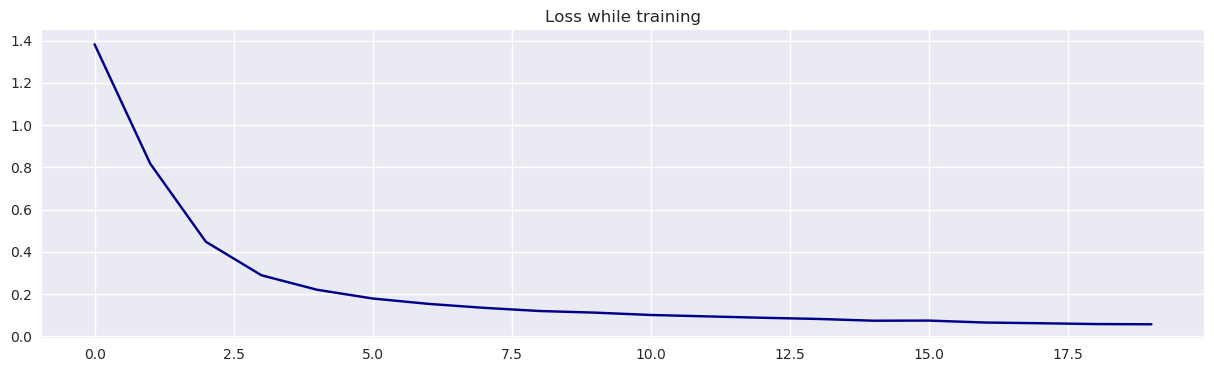

In [39]:
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['loss'], 'darkblue', label = 'Loss')
plt.title("Loss while training")
plt.show()

In [40]:
emotion.m.evaluate(emotion.X_test, emotion.Y_test, batch_size = 256)

8/8 [==============================] - 1s 120ms/step - loss: 0.1765 - accuracy: 0.9370


[0.1765436977148056, 0.9369999766349792]

In [41]:
y_pred = emotion.m.predict(emotion.X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

63/63 [==============================] - 2s 21ms/step


array([4, 0, 5, ..., 0, 2, 2])

In [42]:
y_test = np.argmax(emotion.Y_test, axis = 1)
y_test

array([4, 0, 5, ..., 1, 2, 2])

In [43]:
from sklearn.metrics import accuracy_score as acc
print(acc(y_pred, y_test))

0.937


In [44]:
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

cm = pd.DataFrame(res,
                     index = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'], 
                     columns = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'])
cm

,sadness,anger,love,surprise,fear,joy
sadness,281,5,0,2,8,0
anger,5,214,0,0,10,18
love,3,0,643,18,5,4
surprise,0,0,22,126,0,0
fear,6,5,4,1,550,0
joy,0,9,1,0,0,60


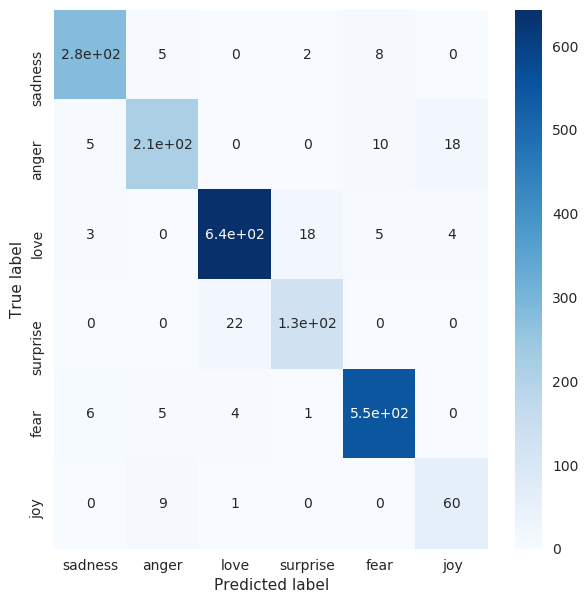

In [45]:
import seaborn as sns
figure = plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
emotion.m.save("emotion.h5")